# Exploratory  Data  Analysis and Model Training

## 1) Exploratory Data Analysis

### Import the Required Libraries

In [2]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LSTM, Embedding, GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt

### Read the Data through Pandas

In [3]:
df1 = pd.read_csv('train.csv')  
df2 = pd.read_csv('youtoxic_english_1000.csv')  

### Data Pre-processing and Analysis

Data Frame 'df1' consists of 6 different features like Toxic, severe_toxic, obscene etc,. representing the toxicity level of a comment. So, we are normalizing the 6 different features into 1 feature "TOXIC" this is done as these features are missing and also there a re several other features that are present in the other dataset.

In [4]:
# Process df1, mark Toxic as 1 if any toxicity class is 1
df1['Toxic'] = df1.iloc[:, 2:].any(axis=1).astype(int)
df1_processed = df1[['comment_text', 'Toxic']].rename(columns={'comment_text': 'Text'})

Check the samples available for each feature in the dataframe 'df1'.

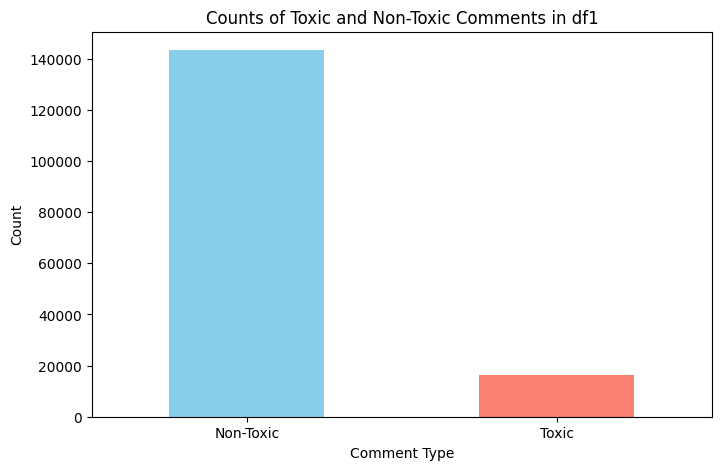

In [5]:
toxicity_counts = df1_processed['Toxic'].value_counts()
toxicity_counts.index = ['Non-Toxic', 'Toxic']

plt.figure(figsize=(8, 5))
toxicity_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Counts of Toxic and Non-Toxic Comments in df1')
plt.xlabel('Comment Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Dataframe 'df2' consists of several other features which are different from dataframe 'df1' so normalise all the features into a single feature "TOXIC". 

In [ ]:
# Process df2, mark Toxic as 1 if any toxicity class is 1
df2['Toxic'] = df2.iloc[:, 3:].any(axis=1).astype(int)
df2_processed = df2[['Text', 'Toxic']]


Check the samples available for each feature in the dataframe 'df1'.

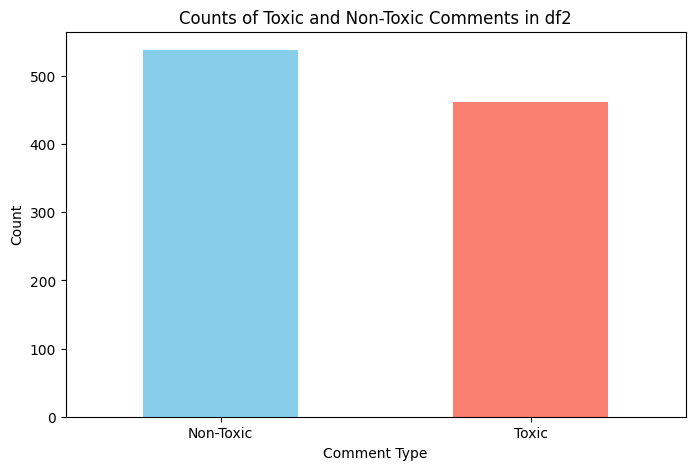

In [12]:
# Plotting the bar plot
toxicity_counts_df2 = df2_processed['Toxic'].value_counts()
toxicity_counts_df2.index = ['Non-Toxic', 'Toxic']

plt.figure(figsize=(8, 5))
toxicity_counts_df2.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Counts of Toxic and Non-Toxic Comments in df2')
plt.xlabel('Comment Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


Combine the dataframes 'df1' and 'df2', this is done as there is high imbalance of number of data samples between the features present in 'df1'. Hence the idea is to combine two different datasets so, that it would be easy to perform Data imbalance techniques like SMOTE and resampled data would be more significant and meaningful. So from the resampled data the model would train well and generalise well on unseen data.

In [5]:
# Combine datasets and remove duplicates
df = pd.concat([df1_processed, df2_processed], ignore_index=True)
df.drop_duplicates(subset=['Text'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

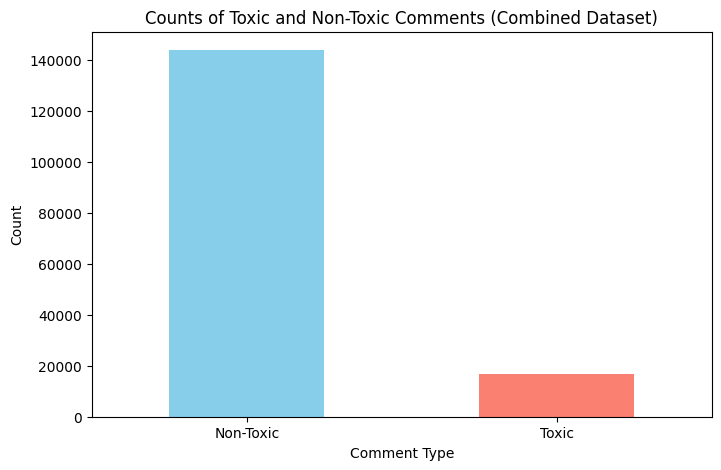

In [13]:
# Plotting the bar plot
toxicity_counts_combined = df['Toxic'].value_counts()
toxicity_counts_combined.index = ['Non-Toxic', 'Toxic']

plt.figure(figsize=(8, 5))
toxicity_counts_combined.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Counts of Toxic and Non-Toxic Comments (Combined Dataset)')
plt.xlabel('Comment Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Below is a Text cleaning function which basically addresses some of the text data present in the both dataframes to remove single apostrophe (') so the model can learn well from these kind of comments.

In [6]:
# Text Cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    return text

df['Text'] = df['Text'].apply(clean_text)

<>:13: SyntaxWarning: invalid escape sequence '\W'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\W'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/qf/crhg50jx3k196n22hszlqs1c0000gn/T/ipykernel_27582/935175143.py:13: SyntaxWarning: invalid escape sequence '\W'
  text = re.sub('\W', ' ', text)
/var/folders/qf/crhg50jx3k196n22hszlqs1c0000gn/T/ipykernel_27582/935175143.py:14: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text).strip()


Performing tokenization and padding to get the tokens based on the context of maximum number of words and maximum length of input at each point of time.

In [7]:
# Tokenization and padding
max_words = 5000
max_len = 150
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Text'])
X = tokenizer.texts_to_sequences(df['Text'])
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len)

Performing Data Imbalance techniques and fitting that into the data.

In [15]:
# SMOTE for balancing
Y = df['Toxic']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, Y)

Visualising the SMOTE result

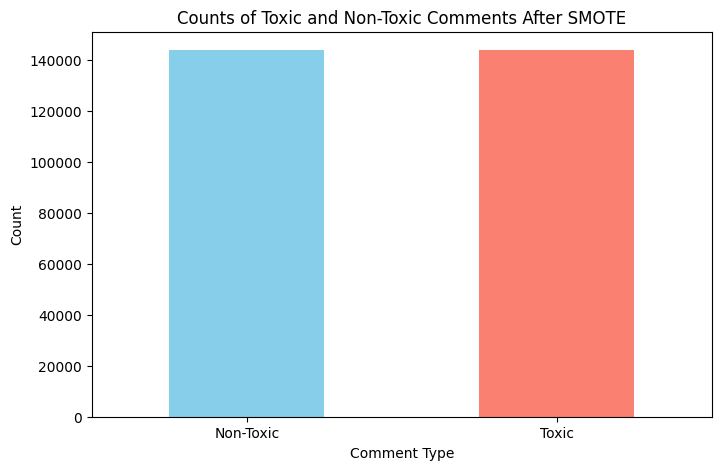

In [16]:
# Plotting the bar chart after SMOTE
toxicity_counts_resampled = y_resampled.value_counts()
toxicity_counts_resampled.index = ['Non-Toxic', 'Toxic']

plt.figure(figsize=(8, 5))
toxicity_counts_resampled.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Counts of Toxic and Non-Toxic Comments After SMOTE')
plt.xlabel('Comment Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Performing Train test split in the ratio of 80:20(Train:Test)

In [14]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## 2) Model Building and Training

Initialising the Embedding layer dimensions and Embedding Layer matrix

In [ ]:
embedding_dim = 100
embedding_matrix = np.random.rand(max_words, embedding_dim)

Model Building

## CNN-LSTM Model Architecture

This section provides an overview of each layer used in the model and the purpose it serves in the architecture.

1. **Embedding Layer**
    - Maps each word to a vector in a dense embedding space of dimension `embedding_dim` (100).
    - Initializes weights with a pre-defined `embedding_matrix`.
    - This embedding helps the model learn semantic relationships between words by representing them in a dense vector space.
    - `trainable=True` allows these embeddings to be fine-tuned during training.

2. **SpatialDropout1D Layer**
    - Drops entire feature maps at random rather than individual nodes.
    - Helps prevent overfitting by adding regularization and allows the model to generalize better.
    - Specifically useful in embedding layers for text data, as it retains spatial structure.

3. **Conv1D Layer**
    - Applies convolution operations to the input sequences, extracting local patterns in the word embeddings.
    - The `kernel_size=3` helps detect trigrams, capturing local dependencies between words in short phrases.
    - The 64 filters increase the feature space, helping the model capture multiple patterns.

4. **LSTM Layer**
    - Captures long-term dependencies in the input sequence, effectively handling the sequential nature of text.
    - `return_sequences=False` outputs a single hidden state, which is suitable for final prediction tasks.
    - The 64 units help retain useful information from prior words while processing the sequence.

5. **Dropout Layer (50%)**
    - Prevents overfitting by randomly dropping half of the units during training.
    - This layer helps the model generalize by reducing reliance on specific nodes.

6. **Dense Layer (64 units)**
    - A fully connected layer with 64 units that introduces non-linearity.
    - Provides a richer representation of the features learned in previous layers.
    - The `relu` activation function helps the network learn complex patterns effectively.

7. **BatchNormalization Layer**
    - Normalizes the output of the previous layer, speeding up training.
    - Helps stabilize learning by reducing internal covariate shift and improving model convergence.

8. **Dropout Layer (50%)**
    - Further regularizes the model by dropping units, helping prevent overfitting.
    - Enhances generalization by reducing reliance on specific neurons.

9. **Output Dense Layer**
    - The output layer with a single unit and `sigmoid` activation function.
    - Produces a probability score between 0 and 1, indicating the likelihood of the comment belonging to a particular class.


In [ ]:
# Building the CNN-LSTM Model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
    SpatialDropout1D(0.2),
    Conv1D(64, kernel_size=3, activation='relu'),
    LSTM(64, return_sequences=False),  
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/Users/saicharanlanka/AOA-CommentToxicity/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:

# Training
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 162s 28ms/step - accuracy: 0.6847 - loss: 0.5701 - val_accuracy: 0.9153 - val_loss: 0.2149
Epoch 2/5
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 164s 29ms/step - accuracy: 0.9182 - loss: 0.2103 - val_accuracy: 0.9454 - val_loss: 0.1453
Epoch 3/5
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 167s 29ms/step - accuracy: 0.9449 - loss: 0.1531 - val_accuracy: 0.9463 - val_loss: 0.1401
Epoch 4/5
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 170s 30ms/step - accuracy: 0.9545 - loss: 0.1306 - val_accuracy: 0.9513 - val_loss: 0.1340
Epoch 5/5
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 171s 30ms/step - accuracy: 0.9591 - loss: 0.1180 - val_accuracy: 0.9561 - val_loss: 0.1199


In [20]:
# Evaluate Model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy}')

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9536 - loss: 0.1252
Test Accuracy: 0.9539041519165039


#### The reported Accuracy is 95.390% and the reported Loss is 0.1252

Ploting the Model Accuracy with respect to Epochs.

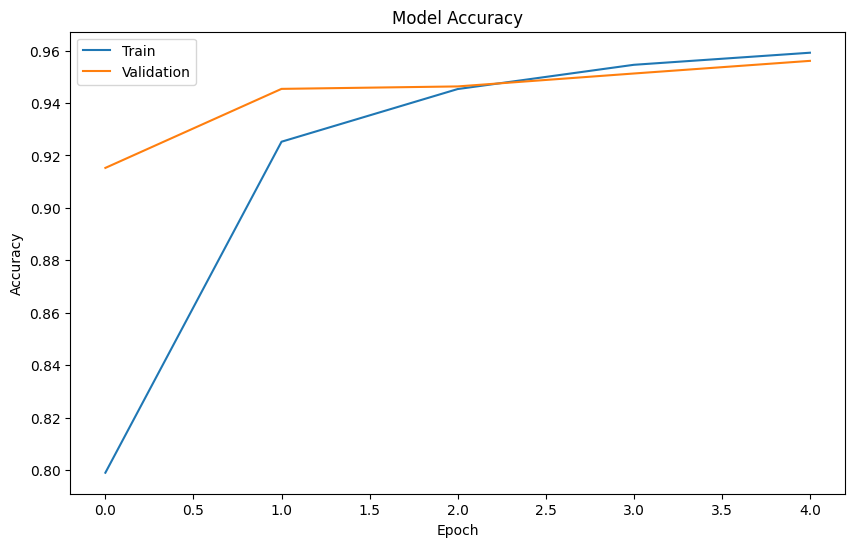

In [21]:
# Plot Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Ploting the Model Loss with respect to Epochs.

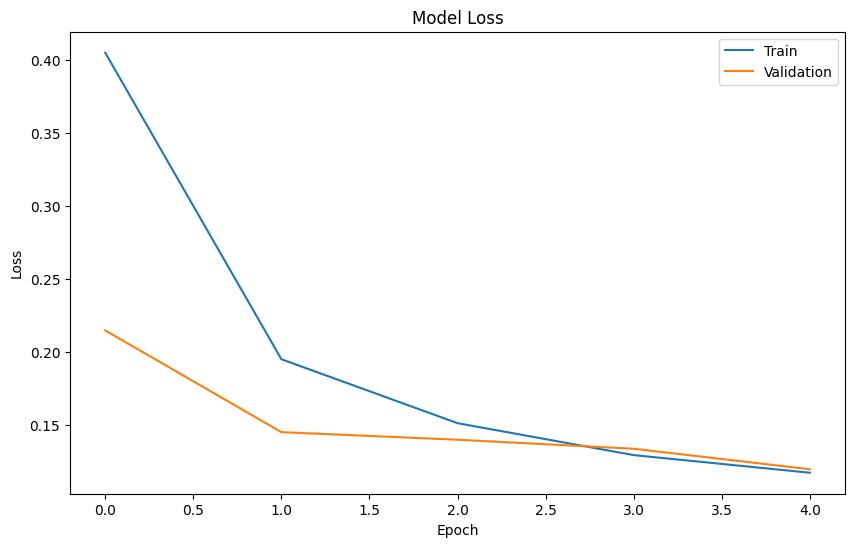

In [22]:
# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Classification Report
y_pred = (model.predict(x_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     28665
           1       0.96      0.95      0.95     28889

    accuracy                           0.95     57554
   macro avg       0.95      0.95      0.95     57554
weighted avg       0.95      0.95      0.95     57554



#### Saving the Model in '.h5' format for deployment purposes and also we might need the tokenizer that we have used earlier during pre-processing so using pickle, the tokenizer is also saved in '.pkl' format.

In [ ]:
# Save Model and Tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
model.save('cnn_lstm_toxic_comment_model.h5')